# Introduction

Barbara wanted histograms for how many determinations were made for each biosample type...

In [1]:
import pandas
import os
from matplotlib import pylab
from urllib.parse import quote
from htsworkflow.submission.encoded import ENCODED


In [2]:
%matplotlib inline

In [3]:
pandas.set_option('display.max_rows', 500)

In [4]:
server = ENCODED('www.encodeproject.org')

In [5]:
def get_biosample_counts(server, species, rfa, lab, assay='polyA+RNA-seq'):
    query = '/matrix/?type=Experiment'\
            '&assay_slims=Transcription'\
            '&assay_title={assay}'\
            '&replicates.library.biosample.donor.organism.scientific_name={species}'\
            '&lab.title={lab}'\
            '&award.rfa={rfa}'
    results = server.get_json(
        query.format(assay=assay, species=quote(species), lab=quote(lab), rfa=quote(rfa))
    )
    
    biosamples = []
    counts = []
    biosample_type = results['matrix']['y']['biosample_type']
    for biosample_type_bucket in biosample_type['buckets']:
        biosample_term_name = biosample_type_bucket['biosample_term_name']
        for biosample_term_name_bucket in biosample_term_name['buckets']:
            #print(species, rfa, lab, biosample_term_name['key'], biosample_term_name['doc_count'])
            biosamples.append((biosample_type_bucket['key'], biosample_term_name_bucket['key']))
            counts.append(int(biosample_term_name_bucket['doc_count']))

    s = pandas.Series(counts, index=biosamples)
    s.name = (rfa, lab)
    return s
        

In [7]:
def make_matrix(species):
    server = ENCODED('www.encodeproject.org')

    labs = {
        'Mus musculus': ['Barbara Wold, Caltech', 'Thomas Gingeras, CSHL', 'John Stamatoyannopoulos, UW',
                         'Bing Ren, UCSD', 'Christina Leslie, MSKCC', 'Ross Hardison, PennState',
                         'Michael Snyder, Stanford'],
        'Homo sapiens': ['John Stamatoyannopoulos, UW', 'Joseph Costello, UCSF', 'Joe Ecker, Salk',
                         'Thomas Gingeras, CSHL', 'Barbara Wold, Caltech', 'Richard Myers, HAIB',
                         'Tim Reddy, Duke', 'Michael Snyder, Stanford', 'Bradley Bernstein, Broad',
                         'Eric Lécuyer, IRCM', 'Brenton Graveley, UConn', 'Sherman Weissman, Yale',
                         'Yijun Ruan, JAX']
    }

    rfas = ['ENCODE2', 'ENCODE2-Mouse', 'ENCODE3', 'ENCODE4', 'Roadmap', 'modENCODE', 'modERN', 'GGR', 'community']

    biosamples = []
    for rfa in rfas:
        for lab in labs[species]:
            counts = get_biosample_counts(server, species, rfa, lab)
            if counts.sum() > 0:
                biosamples.append(counts)

    try:
        determinations = pandas.DataFrame({x.name: x for x in biosamples})
        determinations.fillna(0.0, inplace=True)
        return determinations
    except Exception as e:
        print(e)
        return biosamples

In [8]:
mouse_filename = 'mouse_determinations.pkl'
if not os.path.exists(mouse_filename):
    mouse = make_matrix('Mus musculus')
    mouse.to_pickle(mouse_filename)
else:
    mouse = pandas.read_pickle(mouse_filename)

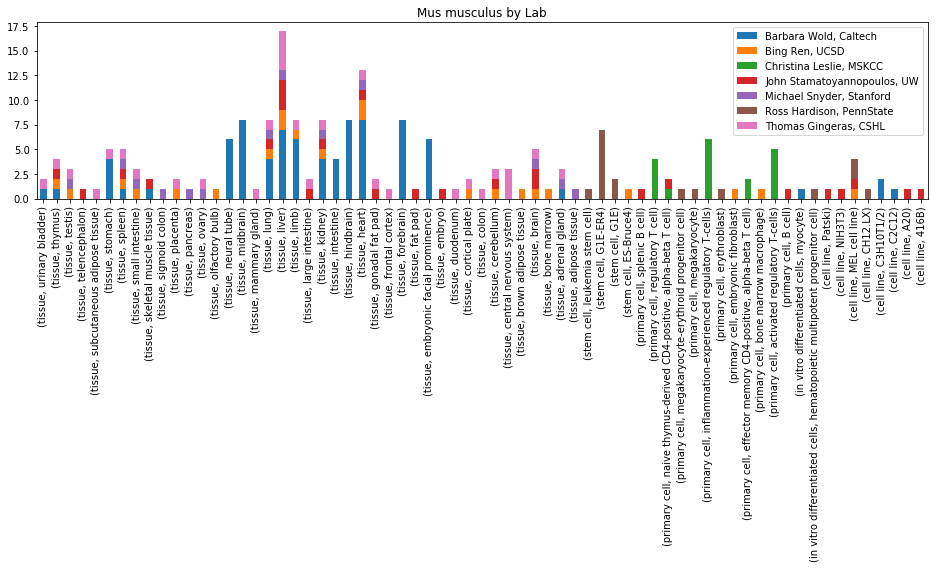

In [9]:
a = mouse.groupby(axis=1, level=1).sum().\
    reindex(reversed(mouse.index)).\
    plot(kind='bar', stacked=True, figsize=(13,8), title='Mus musculus by Lab')
a.figure.tight_layout()
a.figure.savefig('mouse-by-lab.png')

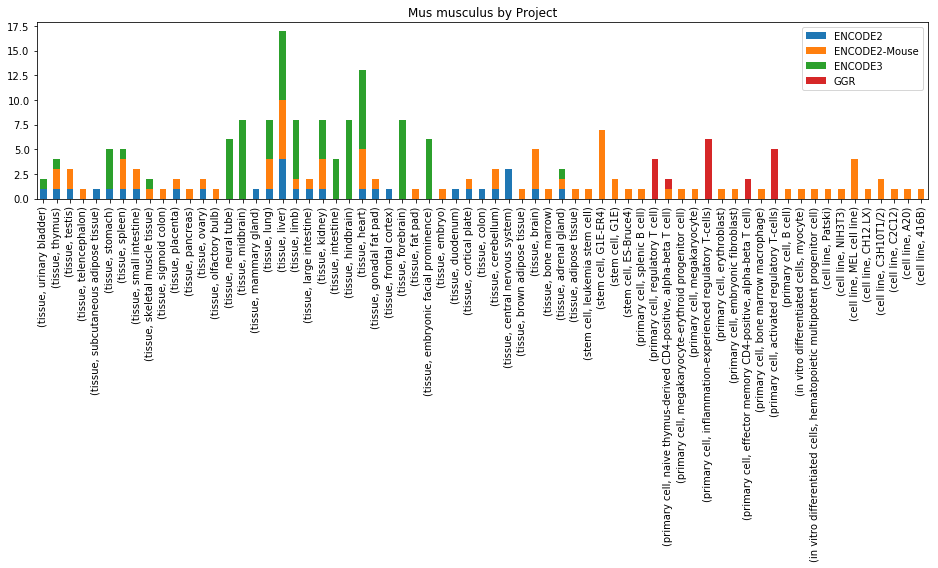

In [10]:
a = mouse.groupby(axis=1, level=0).sum().\
    reindex(reversed(mouse.index)).\
    plot(kind='bar', stacked=True, figsize=(13,8), title='Mus musculus by Project')
a.figure.tight_layout()
a.figure.savefig('mouse-by-project.png')

In [11]:
human_filename = 'human_determinations.pkl'
if not os.path.exists(human_filename):
    human = make_matrix('Homo sapiens')
    human.to_pickle(human_filename)
else:
    human = pandas.read_pickle(human_filename)

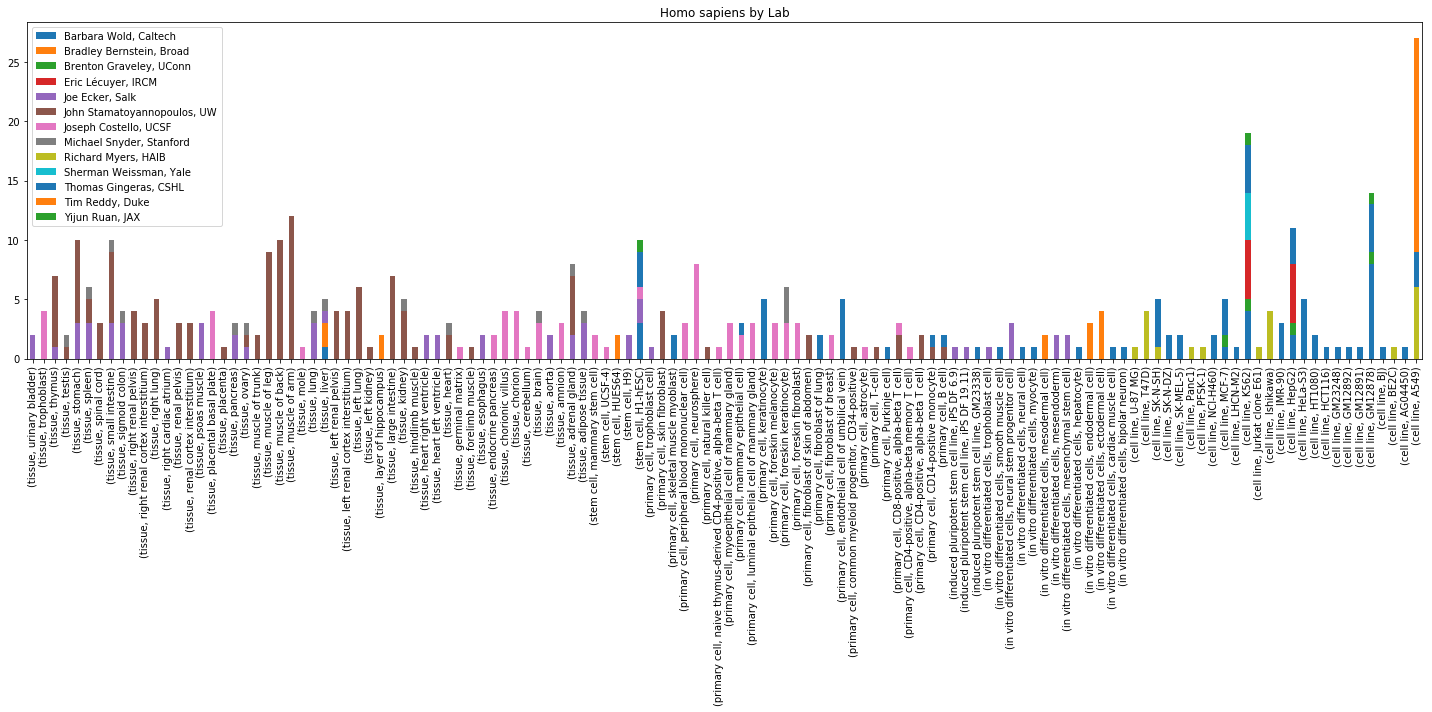

In [13]:
a = human.groupby(axis=1, level=1).\
    sum().reindex(reversed(human.index)).\
    plot(kind='bar', stacked=True, figsize=(20,10), title='Homo sapiens by Lab')
a.figure.tight_layout()
a.figure.savefig('human-by-lab.png')

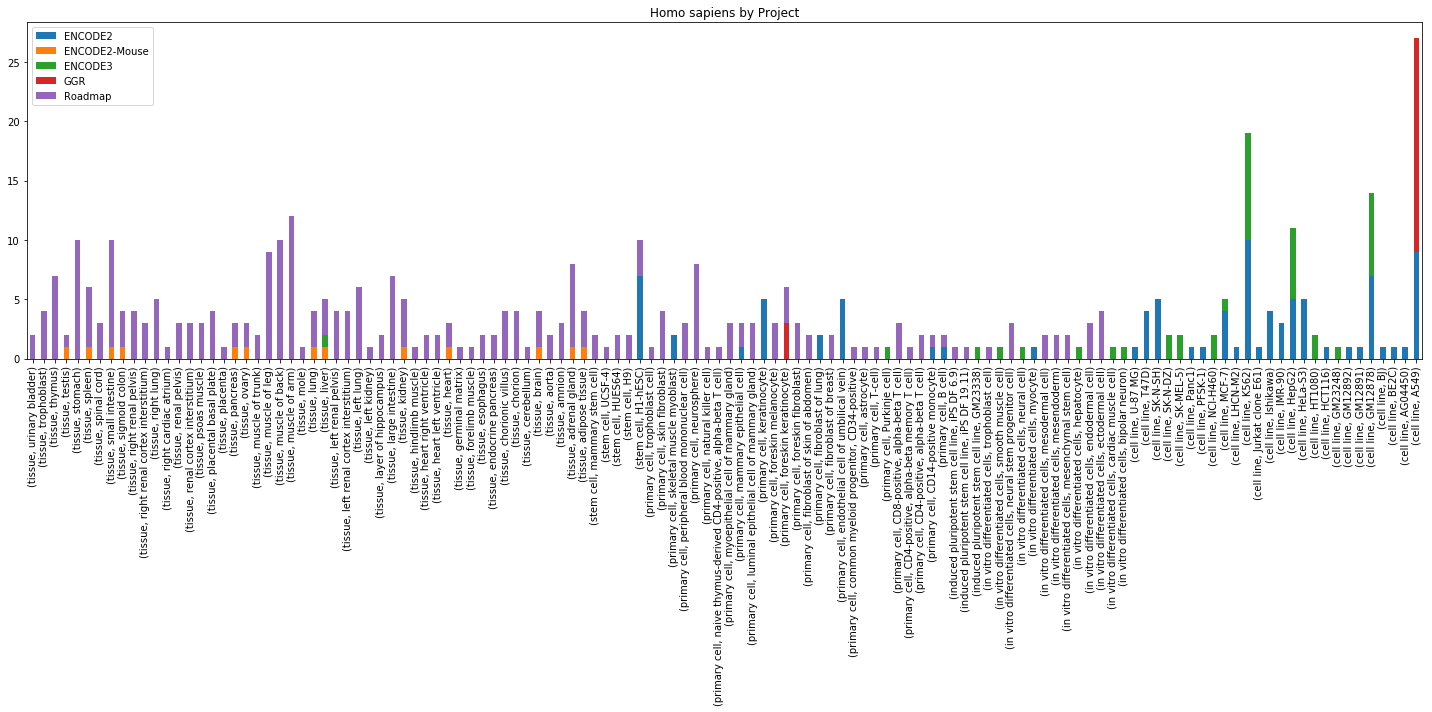

In [14]:
a = human.groupby(axis=1, level=0).sum().\
    reindex(reversed(human.index)).\
    plot(kind='bar', stacked=True, figsize=(20,10), title='Homo sapiens by Project')
a.figure.tight_layout()
a.figure.savefig('human-by-project.png')

Url for pulling up list of experiments for the biosample count we had above

In [15]:
experiments = 'https://www.encodeproject.org/search/?type=Experiment&assay_slims=Transcription'\
              '&assay_title=polyA+RNA-seq&replicates.library.biosample.donor.organism.scientific_name={species}'\
              '&lab.title={lab}&award.rfa={rfa}&biosample_term_name={biosample_term_name}&assay_title=polyA+RNA-seq'